# Case Study 2 - Spatial projection via modelled data
## Description 
Estimate soil pH and electrical conductivity at 45 cm depth across the Llara-Campey farm sites based on values collected from soil samples across the farm. 

This is an example of predicting a spatial variable across a region based on a calculation dependent on data for multiple other spatial variables. Comparable cases could include:
- Analyse expected yield for different chickpea and wheat varieties if these were grown across Western Australia under actual seasonal weather conditions, so I can estimate the benefit associated with optimised varietal selection. 
- Predict population levels for a pest species across a region based on a function derived from Case Study 1 and environmental context for the region at the time and over the previous month, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5).

## Imports

In [11]:
import rioxarray
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
import pystac
import pystac_client
import subprocess
import json
import pykrige

from stac_generator.factory import StacGeneratorFactory
from stac_generator.core.base.generator import StacSerialiser
from stac_generator.core.base.schema import StacCollectionConfig, ColumnInfo
from stac_generator.core.raster.schema import RasterConfig, BandInfo
from stac_generator.core.vector.schema import VectorConfig
from stac_generator.core.point.schema import PointConfig

from mccn.client import MCCN

from rocrate.rocrate import ROCrate
from rocrate.model import ComputationalWorkflow, File, Dataset, ContextEntity, Person

## Data Paths
Locations for folders and files used in this notebook.

In [ ]:
# Paths to current folder and scratch folder for working files
current_folder = os.getcwd()
source_folder = os.path.join(current_folder, "source_data")
stac_folder = os.path.join(current_folder, "stac")
scratch_folder = os.path.join(current_folder, "scratch")
results_folder = os.path.join(current_folder, "results")

# Create clean folders for outputs
for f in [stac_folder, scratch_folder, results_folder]:
    if os.path.exists(f):
        shutil.rmtree(f)
    os.makedirs(f)

# Path to this notebook
notebook = "MCCN-CASE 2.ipynb"

# Paths to source files
soil_source = os.path.join(source_folder, "BradGinns_SOIL2004_SoilData.csv")
boundary_source = os.path.join(source_folder, "Llara_Campey_field_boundaries_poly.shp")

# Paths to working files
soil_datafile = os.path.join(scratch_folder, "SoilData.csv")

# Paths to results files
datacube_initial = os.path.join(results_folder, "Projection_study_initial.dc")
datacube_final = os.path.join(results_folder, "Projection_study_final.dc")
soil_training_file = os.path.join(results_folder, "Projection_soil_training.csv")
soil_sample_file = os.path.join(results_folder, "Projection_soil_sample.csv")
soil_error_file = os.path.join(results_folder, "Projection_soil_error_results.csv")

# Path to generated RO-Crate results package
ro_crate = "MCCN-CASE 2.RO-Crate.zip"
if os.path.exists(ro_crate):
    os.remove(ro_crate)

## Prepare soil data
Read data from 2004 soil dataset. Limit to samples at 45cm depth and for pH or EC. Save data for reference. Split data into a training set for estimating the variables and a smaller set (20% of records) for assessing errors.

In [ ]:

# Read soil_source and keep elements to be used in analysis
soil_data = pd.read_csv(soil_source, encoding="UTF8")[["Site", "Lat", "Long", "mid-depth", "pH", "EC"]].rename(columns={"mid-depth": "Depth"})
soil_data = soil_data[soil_data["Depth"] == 0.45].drop(columns=["Depth"])
soil_data.to_csv(soil_datafile, index=False)

# Select random subset to test results of interpolation methods
soil_data_sample = soil_data.sample(frac=0.2).rename(columns={"pH": "pHSample", "EC": "ECSample"})
soil_data_sample.to_csv(soil_sample_file, index=False)

# Treat all other samples as training data
soil_data_training = soil_data[~soil_data.index.isin(soil_data_sample.index)].rename(columns={"pH": "pHTraining", "EC": "ECTraining"})
soil_data_training.to_csv(soil_training_file, index=False)

## Generate configuration files for STAC collection

In [14]:
# Configuration for collection as a whole.
collection_config = StacCollectionConfig(
    id="SoilStudy",
    title="Datasets for soil case study",
    description="STAC records for accessing datasets to explore as part of the MCCN case study 2 relating to interpolation of soils data",
    license="CC-BY-4.0",
)

# List of configurations for individual data layers.
configurations = [
    
    VectorConfig(
        id="Site_Boundary",
        location=boundary_source,
        collection_date="2024-12-31",
        collection_time="00:00:00"
    ),
    
    PointConfig(
        id="Soil data",
        location=soil_datafile,
        collection_date="2004-12-31",
        collection_time="00:00:00",
        X="Long",
        Y="Lat",
        #Z="Depth",
        column_info=[
            ColumnInfo(name="pH", description=f"pH measurement for given location and depth"),
            ColumnInfo(name="EC", description=f"EC measurement for given location and depth"),
        ]
    ),

    PointConfig(
        id="Soil data sample",
        location=soil_sample_datafile,
        collection_date="2004-12-31",
        collection_time="00:00:00",
        X="Long",
        Y="Lat",
        #Z="Depth",
        column_info=[
            ColumnInfo(name="pHSample", description=f"pH measurement for given location and depth"),
            ColumnInfo(name="ECSample", description=f"EC measurement for given location and depth"),
        ]
    ),

    PointConfig(
        id="Soil data training",
        location=soil_training_datafile,
        collection_date="2004-12-31",
        collection_time="00:00:00",
        X="Long",
        Y="Lat",
        #Z="Depth",
        column_info=[
            ColumnInfo(name="pHTraining", description=f"pH measurement for given location and depth"),
            ColumnInfo(name="ECTraining", description=f"EC measurement for given location and depth"),
        ]
    )

]

# Build the generator using the configurations.
generator = StacGeneratorFactory.get_collection_generator(
    source_configs=configurations,
    collection_config=collection_config
)

# Serialise the STAC collection. This will generate the collection JSON file and item JSON files for each layer.
serialiser = StacSerialiser(generator, stac_folder)
serialiser()

2025-05-22T12:23:40-stac_generator.core.vector.generator - INFO - Reading vector asset: Site_Boundary
2025-05-22T12:23:40-stac_generator.core.point.generator - INFO - Reading point asset: Soil data
2025-05-22T12:23:40-stac_generator.core.point.generator - INFO - Reading point asset: Soil data sample
2025-05-22T12:23:40-stac_generator.core.point.generator - INFO - Reading point asset: Soil data training
2025-05-22T12:23:42-stac_generator.core.base.generator - INFO - successfully save collection SoilStudy to /home/dhobern/Projects/mccn-case-studies/Case 2/stac


## DataCube Load
Load data for all STAC items for the site boundaries and soil data (including the training and sample subsets).

In [15]:
# Using the locally generated collection
endpoint = os.path.join(stac_folder, "collection.json")
client = MCCN(endpoint, shape=(200,100), nodata={"Site_Boundary": 0}, nodata_fallback=np.nan)
ds = client.load()
MCCN.to_netcdf(ds, datacube_initial)

# The xarray includes a time dimension with a single position. Removing this dimension simplifies the indexing in all later steps.
boundary_data = np.fmax(ds["Site_Boundary"].isel(time=0), ds["Site_Boundary"].isel(time=1))
ds = ds.isel(time=0)
ds["Site_Boundary"] = boundary_data

# Display DataSet.
ds

<xarray.Dataset> Size: 982kB
Dimensions:        (y: 100, x: 200)
Coordinates:
  * y              (y) float64 800B -30.25 -30.26 -30.26 ... -30.29 -30.29
  * x              (x) float64 2kB 149.8 149.8 149.8 149.8 ... 149.9 149.9 149.9
    spatial_ref    int32 4B 4326
    time           datetime64[ns] 8B 2004-12-30T13:00:00
Data variables:
    Site_Boundary  (y, x) int8 20kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    EC             (y, x) float64 160kB nan nan nan nan nan ... nan nan nan nan
    pH             (y, x) float64 160kB nan nan nan nan nan ... nan nan nan nan
    pHSample       (y, x) float64 160kB nan nan nan nan nan ... nan nan nan nan
    ECSample       (y, x) float64 160kB nan nan nan nan nan ... nan nan nan nan
    ECTraining     (y, x) float64 160kB nan nan nan nan nan ... nan nan nan nan
    pHTraining     (y, x) float64 160kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    Site_Boundary:  {"0": "nodata", "1": "Site_Boundary"}

## Interpolate data
For each variable, use three different 2D interpolation methods from rioxarray (nearest, linear and cubic) and one from pykrige (linear) to estimate values at other locations in area. Crop these estimates to the boundaries of the farm. 

Note that the rioxarray linear and cubic interpolations are restricted to the convex hull of the available points, so some of the farm areas are not included in their estimates.

Repeat each calculation for the training datasets.

In [16]:
soil_data["Long"]

2      149.852680
7      149.884838
11     149.838791
16     149.830843
21     149.837390
          ...    
298    149.885646
300    149.890011
302    149.877422
304    149.878358
306    149.878810
Name: Long, Length: 110, dtype: float64

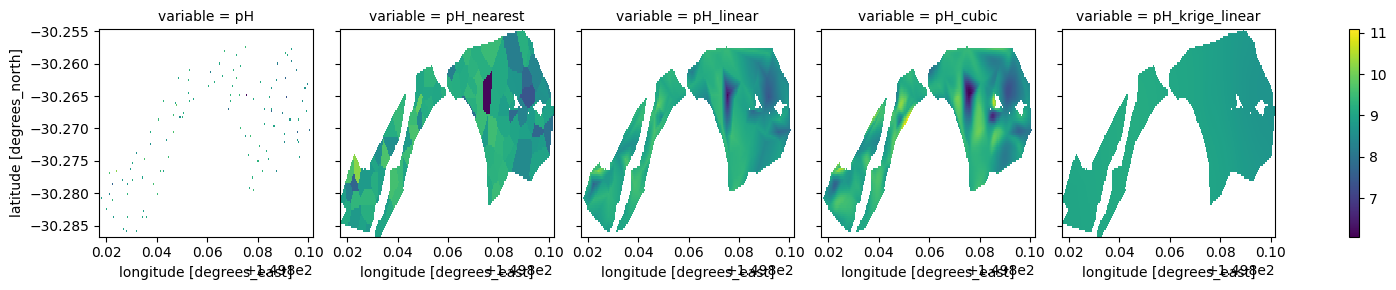

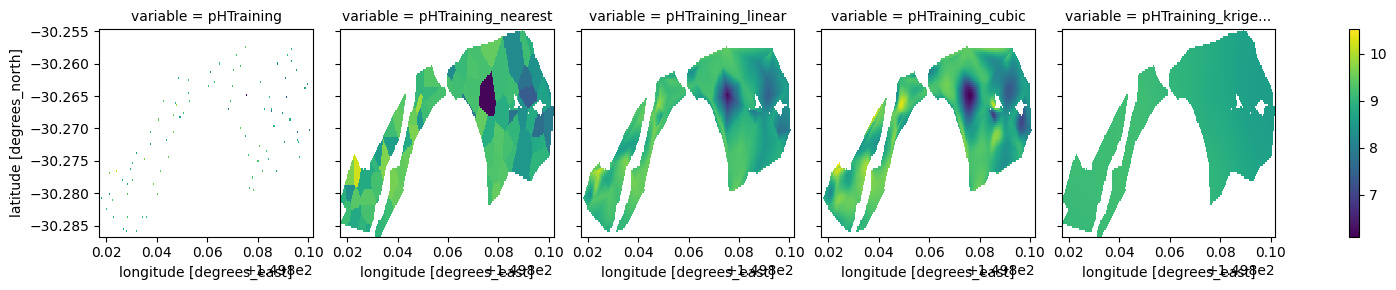

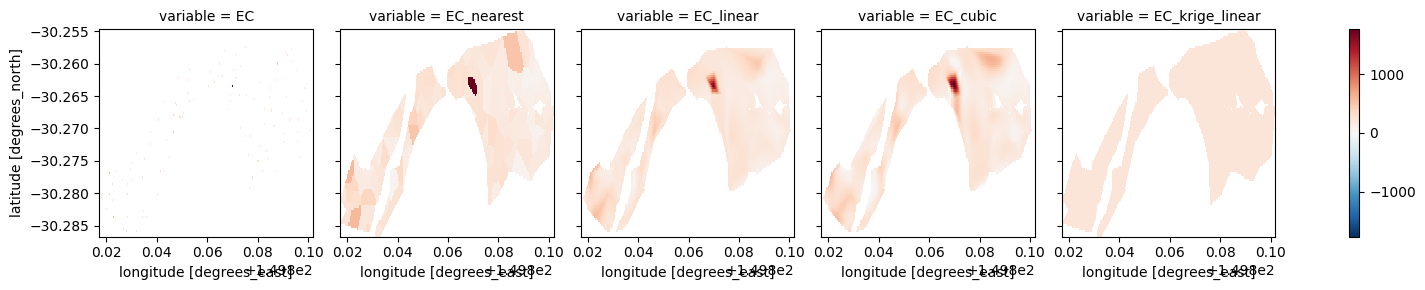

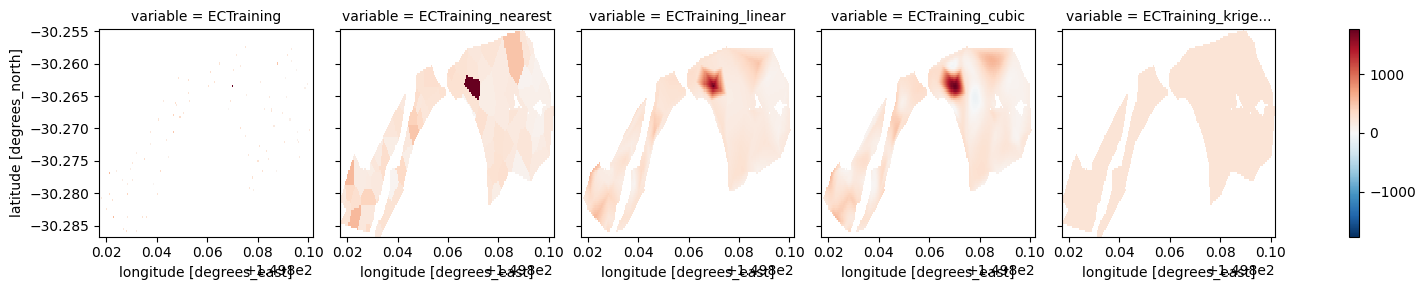

In [17]:
variables = {"pH": [], "pHTraining": [], "EC": [], "ECTraining": []}

for v in variables.keys():
    ds[v].rio.write_nodata(np.nan, encoded=True, inplace=True)
    variables[v].append(v)
    for m in ["nearest", "linear", "cubic", "krige_linear"]:
        name = f"{v}_{m}"
        variables[v].append(name)
        if m.startswith("krige"):
            krige_data = soil_data_training if "Training" in v else soil_data
            OK = pykrige.ok.OrdinaryKriging(krige_data["Long"], krige_data["Lat"], krige_data[v], verbose=False, enable_plotting=False)
            ds[name] = xr.DataArray(OK.execute("grid", list(ds.x), list(ds.y))[0], coords={"y": ds.y, "x": ds.x})
        else:
            ds[name] = ds[v].rio.interpolate_na(method=m)
        ds[name] = ds[name].where(ds["Site_Boundary"] > 0, np.nan)

    ds[variables[v]].to_array().plot(x="x", col="variable", col_wrap=5)

## Calculate errors
Use the 20% sample data set aside earlier to test the interpolations. Compare values at each sample point and calculate error.

In [18]:
s = soil_data_sample.copy()
for _, row in s.iterrows():
    for c in ["pH", "EC"]:
        cs = f"{c}Sample"
        ct = f"{c}Training"
        for v in variables[ct]:
            if not v.endswith("Training"):
                ve = f"{v}_error"
                if ve not in soil_data_sample.columns:
                    soil_data_sample[ve] = np.nan
                estimate = ds[v].sel(x=row["Long"], y=row["Lat"], method="nearest").values
                soil_data_sample.loc[(soil_data_sample["Long"] == row["Long"]) & (soil_data_sample["Lat"] == row["Lat"]), [v, ve]] = [estimate, abs(estimate - row[cs])]

soil_data_sample

,Site,Lat,Long,pHSample,ECSample,pHTraining_nearest_error,pHTraining_nearest,pHTraining_linear_error,pHTraining_linear,pHTraining_cubic_error,...,pHTraining_krige_linear_error,pHTraining_krige_linear,ECTraining_nearest_error,ECTraining_nearest,ECTraining_linear_error,ECTraining_linear,ECTraining_cubic_error,ECTraining_cubic,ECTraining_krige_linear_error,ECTraining_krige_linear
218,TF5,-30.282951,149.835082,8.86,154,0.27,9.13,0.251875,9.111875,0.259189,...,0.269508,9.129508,105.0,259.0,88.937500,242.937500,99.382327,253.382327,85.170455,239.170455
76,S23,-30.277575,149.834507,8.91,222,0.75,9.66,0.515613,9.425613,0.818749,...,0.229766,9.139766,84.0,306.0,66.028302,155.971698,95.410337,126.589663,17.170455,239.170455
296,TX3,-30.265446,149.878549,9.11,177,2.94,6.17,1.764508,7.345492,2.065262,...,0.317807,8.792193,50.0,127.0,38.233161,138.766839,272.694362,-95.694362,62.170455,239.170455
220,TG2,-30.268590,149.850257,9.33,276,0.18,9.15,0.144419,9.185581,0.703125,...,0.197576,9.132424,64.0,212.0,72.810631,203.189369,8.855896,267.144104,36.829545,239.170455
166,TAC2,-30.262587,149.887641,8.71,129,0.51,8.20,0.309322,8.400678,0.595662,...,0.079499,8.630501,368.0,497.0,116.519774,245.519774,106.809920,235.809920,110.170455,239.170455
66,S21,-30.276896,149.843088,8.99,129,0.45,9.44,0.490758,9.480758,0.638031,...,0.186399,9.176399,223.0,352.0,50.231225,179.231225,65.959096,194.959096,110.170455,239.170455
224,TG4,-30.261129,149.853303,9.34,281,0.02,9.32,NaN,NaN,NaN,...,0.263487,9.076513,10.0,291.0,NaN,NaN,NaN,NaN,41.829545,239.170455
302,TZ1,-30.271226,149.877422,9.52,321,0.69,8.83,0.535946,8.984054,0.846135,...,0.628542,8.891458,155.0,166.0,130.189189,190.810811,193.028469,127.971531,81.829545,239.170455
85,S25,-30.266035,149.897947,8.58,132,0.06,8.64,0.246920,8.333080,0.591923,...,0.037843,8.542157,35.0,97.0,37.392857,94.607143,48.229458,83.770542,107.170455,239.170455
139,S8,-30.258601,149.891230,9.23,245,0.09,9.14,0.514444,8.715556,0.295019,...,0.630000,8.600000,15.0,230.0,39.333333,284.333333,57.279109,302.279109,5.829545,239.170455


## Compare methods
Calculate the mean error and standard deviation of the errors for each method for each variable.

This comparison is of limited value. In reality, the variables in question seem to vary significantly at fine scales, so all interpolation methods have poor results.

Depending on which points were selected for the sample, different methods may seem to fit the sample better. In most cases, the pykrige linear model has the best fit. 

In [19]:
errors = pd.DataFrame(columns=["variable", "method", "mean", "std"])
for c in soil_data_sample.columns:
    if "error" in c:
        variable = c[0:2]
        method = " ".join(c.split("_")[1:-1])
        mean = soil_data_sample[c].mean()
        std = soil_data_sample[c].std()
        errors.loc[len(errors)] = [variable, method, mean, std]
        #print(f"{c} - mean error: {soil_data_sample[c].mean():.3f}, error standard error: {soil_data_sample[c].std():.3f}")

errors

,variable,method,mean,std
0,pH,nearest,0.649545,0.870804
1,pH,linear,0.590171,0.616775
2,pH,cubic,0.735888,0.666244
3,pH,krige linear,0.370930,0.309514
4,EC,nearest,84.227273,81.461023
5,EC,linear,153.267356,220.801063
6,EC,cubic,193.945498,263.870595
7,EC,krige linear,63.728306,38.342466


## Cleanup
Beware - this will delete all generated files.

In [ ]:
# Clean up scratch folder
if os.path.exists(scratch_folder):
    shutil.rmtree(scratch_folder)

# Save output datasets
MCCN.to_netcdf(ds, datacube_final)
errors.to_csv(soil_error_file)

# Package notebook, source data and outputs as an RO-Crate
crate = ROCrate()
ardc = crate.add(ContextEntity(crate, "https://ror.org/038sjwq14", properties={
    "@type": "Organisation",
    "name": "Australian Research Data Commons"
}))
appn = crate.add(ContextEntity(crate, "https://ror.org/02zj7b759", properties={
    "@type": "Organisation",
    "name": "Australian Plant Phenomics Network"
}))
dgh = crate.add(Person(crate, "https://orcid.org/0000-0001-6492-4016", properties={
    "name": "Donald Hobern",
    "email": "donald.hobern@adelaide.edu.au",
    "affiliation": {"@id": appn.id},
    "jobTitle": "APPN Data Management Director",
}))
food_security = crate.add(ContextEntity(crate, "https://doi.org/10.47486/DC105", properties={
    "@type": "Grant",
    "name": "ARDC Project Code DC105: Multi-Scalar Crop Characterisation Network (MCCN)",
    "funder": {"@id": ardc.id}
}))
mccn = crate.add(ContextEntity(crate, "https://doi.org/10.26292/8679d473", properties={
    "@type": "ResearchActivity",
    "name": "Multi-Scalar Crop Characterisation Network (MCCN)",
    "funding": {"@id": food_security.id},
    "contactPoint": {"@id": dgh.id},
}))
cc_by = crate.add(ContextEntity(crate, "https://creativecommons.org/licenses/by/4.0/", properties={
    "@type": "License",
    "name": "Creative Commons Attribution 4.0 International (CC BY 4.0)",
}))
crate_properties = crate.default_entities[0].properties()
crate_properties |= {
    "name": "MCCN Case Study 2 - source data, notebook and results",
    "description": "This RO-Crate is a packaged version of the Jupyter notebook for Case Study 2 of the Multiscalar Crop Characterisation Network (MCCN) project. It demonstrates the functionality of the Python packages pystac-generator and mccn-engine developed as part of this project.",
    "license": {"@id": cc_by.id},
    "isBasedOn": {"@id": mccn.id},
}
soil_source = os.path.join(source_folder, "BradGinns_SOIL2004_SoilData.csv")
boundary_source = os.path.join(source_folder, "Llara_Campey_field_boundaries_poly.shp")

crate.add(File(crate, source=(soil_source := os.path.relpath(soil_source, current_folder)), dest_path=soil_source, properties={
    "name": "Soil measurements from 2004, corresponding to sites L1, L3 and L4 describing mid-depth, soil apparent electrical conductivity (ECa), GammaK, Clay, Silt, Sand, pH and soil electrical conductivity (EC)",
    "encodingFormat": "text/csv",
    "producer": "usyd.edu.au",
    "citation": "University of Sydney",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://object-store.rc.nectar.org.au/v1/AUTH_2b454f47f2654ab58698afd4b4d5eba7/mccn-test-data/LlaraCampey/soil_data.csv"}
}))
crate.add(File(crate, source=(boundary_source := os.path.relpath(boundary_source, current_folder)), dest_path=boundary_source, properties={
    "name": "Shape file of outer boundary for wheat experiments conducted at Llara farm site L1, L3, L4 in 2017, 2019 and 2021 measuring yield, elevation and moisture",
    "encodingFormat": "application/octet-stream",
    "producer": "usyd.edu.au",
    "citation": "University of Sydney",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://object-store.rc.nectar.org.au/v1/AUTH_2b454f47f2654ab58698afd4b4d5eba7/mccn-test-data/LlaraCampey/boundary_wgs84.zip"}
}))
crate.add(File(crate, source=(datacube_initial := os.path.relpath(datacube_initial, current_folder)), dest_path=datacube_initial, properties={
    "name": "Xarray datacube as loaded from source data files by MCCN Case Study 2",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=(datacube_final := os.path.relpath(datacube_final, current_folder)), dest_path=datacube_final, properties={
    "name": "Xarray datacube following processing by MCCN Case Study 2",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=(soil_data_training := os.path.relpath(soil_data_training, current_folder)), dest_path=soil_data_training, properties={
    "name": "CSV table of soil data selected to build kriged layers",
    "license": {"@id": cc_by.id},
    "encodingFormat": "text/csv",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=(soil_data_sample := os.path.relpath(soil_data_sample, current_folder)), dest_path=soil_data_sample, properties={
    "name": "CSV table of soil data selected to test kriged layers",
    "license": {"@id": cc_by.id},
    "encodingFormat": "text/csv",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=(soil_error_file := os.path.relpath(soil_error_file, current_folder)), dest_path=soil_error_file, properties={
    "name": "CSV table of differences/errors when comparing test soil data with kriged layers",
    "license": {"@id": cc_by.id},
    "encodingFormat": "text/csv",
    "producer": {"@id": appn.id},
}))
crate.add(ComputationalWorkflow(crate, source=notebook, dest_path=notebook, properties={
    "name": "MCCN Case Study 2 Notebook: Spatial projection via modelled data",
    "encodingFormat": "application/x-ipynb+json",
    "creator": {"@id": dgh.id},
    "license": {"@id": cc_by.id},
    "isBasedOn": {"@id": mccn.id},
    "input": [
        { "@id": soil_source},
        { "@id": boundary_source},
    ],
    "output": [
        { "@id": datacube_initial},
        { "@id": datacube_final},
        { "@id": soil_training_file},
        { "@id": soil_sample_file},
        { "@id": soil_error_file},
    ],
}))
crate.write_zip(ro_crate)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().